In [59]:
import sklearn
sklearn.__version__

'1.0.2'

In [60]:
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math #
from sklearn import preprocessing #
from statistics import mean, stdev

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.metrics import auc, precision_score, accuracy_score,recall_score

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold #
from sklearn.model_selection import cross_validate #

from sklearn.ensemble import RandomForestClassifier #
from sklearn.tree import DecisionTreeClassifier
import time


# some notebook settings
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(precision=4, suppress=True, linewidth=110)

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 2000)  # or 1000
pd.set_option('display.max_colwidth', None)

import seaborn as sns
sns.set_theme()

from sklearn import datasets
from sklearn import tree

# graphviz
# conda install -c conda-forge python-graphviz
import graphviz

In [61]:
#read the data
df = pd.read_csv('data/clean_holmes_2019.csv')
cols_to_del = list()
for col in df.columns.tolist():
    if 'class_1_' in col:
            cols_to_del.append(col)
        
    if 'month' in col:
        cols_to_del.append(col)
        
cols_to_del.append('class_7_radioactive_material')

df.drop(cols_to_del,axis=1,inplace=True)
df.head()

,class_2_1_flammable_gases,class_2_2_non_flammable_non_toxic_gases,class_2_3_toxic_gases,class_3_flammable_liquids,class_4_1_flammable_solids,class_4_2_spontaneous_combustion,class_4_3_flammable_gases_in_contact_water,class_5_1_oxidizing_substances,class_5_2_organic_peroxides,class_6_1_toxic_substances,class_6_2_infectious_substances,class_8_corrosives,class_9_miscellaneous_dangerous_goods,PG_I_high_danger,PG_II_medium_danger,PG_III_low_danger,Quantity_total,Nr_dif_UNNRs,Packaging_DRUM_yn,Packaging_JERRYCAN_yn,Packaging_BOX_yn,Packaging_BAG_yn,Packaging_COMPOSITE_yn,Packaging_UNPACKED_yn,Packaging_IBC_yn,Packaging_LP_yn,Packaging_Bulk_container_yn,Packaging_PR_yn,METAL_packaging_yn,WOODEN_packaging_yn,PLASTIC_packaging_yn,OTHER_packing_material_yn,Prisma_object_type_corrected_Container,Prisma_object_type_corrected_IMO or UN transport tank,Prisma_in_outgoing_corrected_Incoming,Prisma_in_outgoing_corrected_Outgoing or Transshipment,Prisma_terminal_corrected_APM Terminals Maasvlakte II,Prisma_terminal_corrected_APM Terminals Rotterdam,Prisma_terminal_corrected_ECT Delta Terminal,Prisma_terminal_corrected_Euromax Terminal,Prisma_terminal_corrected_Other terminal,Prisma_terminal_corrected_Rotterdam World Gate Terminal (RWG),Prisma_region_origin_incoming_corrected_Africa,Prisma_region_origin_incoming_corrected_China,Prisma_region_origin_incoming_corrected_India,Prisma_region_origin_incoming_corrected_Latin_America,Prisma_region_origin_incoming_corrected_Middle_East,Prisma_region_origin_incoming_corrected_Rest_of_the_world,Prisma_region_origin_incoming_corrected_South_East_Asia,Prisma_region_destination_incoming_corrected_Europe,Prisma_region_destination_incoming_corrected_Netherlands,Prisma_region_destination_incoming_corrected_Rest_of_the_world,Prisma_cargo_agent_corrected_8 - CMA CGM (Holland) B.V.,Prisma_cargo_agent_corrected_20 - Hapag-Lloyd Rotterdam,Prisma_cargo_agent_corrected_22 - Hyundai Merchant Marine,Prisma_cargo_agent_corrected_24 - Maersk Line,Prisma_cargo_agent_corrected_25 - Mediterranean Shipping Company,Prisma_cargo_agent_corrected_27 - Mueller Liner Agency,Prisma_cargo_agent_corrected_30 - Ocean Network Express (ONE),Prisma_cargo_agent_corrected_Other_cargo_agent,target,spec_container_type_Bulk Container,spec_container_type_General Purpose Container,spec_container_type_IMO Tankcontainer,spec_container_type_Reefer Container,spec_container_type_UN MEGC,spec_container_type_UN transporttank,transportation_mode_Containership,transportation_mode_General Cargo ship,transportation_mode_RoRo,transportation_mode_Roro,transportation_mode_missing,transportation_type_Deep Sea,transportation_type_Short Sea,transportation_type_missing
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,7250.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,10050.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,12300.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,16000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7269.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


<AxesSubplot:>

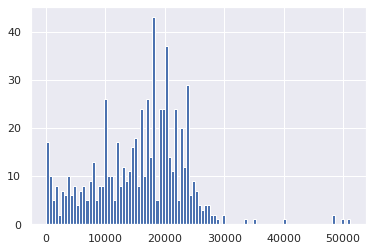

In [142]:
df.Quantity_total.hist(bins=100)

<AxesSubplot:>

<AxesSubplot:>

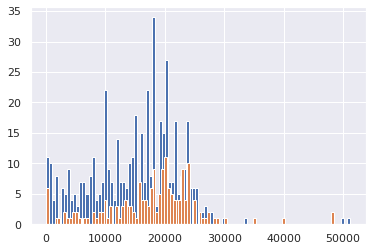

In [146]:
df.loc[df['target'] ==1,'Quantity_total'].hist(bins=100)
df.loc[df['target'] ==0,'Quantity_total'].hist(bins=100)

In [62]:
#just checking if we deleted the instances that might cause leakage(quantity = 0 or 1)
(df['Quantity_total']<2).sum()

0

In [63]:
y = df.target.copy()
X = df.drop('target',axis=1)           

In [64]:
#checking out
X.dtypes

class_2_1_flammable_gases                                             int64
class_2_2_non_flammable_non_toxic_gases                               int64
class_2_3_toxic_gases                                                 int64
class_3_flammable_liquids                                             int64
class_4_1_flammable_solids                                            int64
class_4_2_spontaneous_combustion                                      int64
class_4_3_flammable_gases_in_contact_water                            int64
class_5_1_oxidizing_substances                                        int64
class_5_2_organic_peroxides                                           int64
class_6_1_toxic_substances                                            int64
class_6_2_infectious_substances                                       int64
class_8_corrosives                                                    int64
class_9_miscellaneous_dangerous_goods                                 int64
PG_I_high_da

In [65]:
%%capture
import time
now=time.time()


max_precisions = list() #this is the lsit with the best scores only
mean_performance=list()
best_alphas = list()
std_performance = list()
all_models=list()

skf_in = StratifiedKFold(n_splits = 10, shuffle=True)
skf_out = StratifiedKFold(n_splits = 10, shuffle=False)


#outer loop for crossval.keeping fixed indices
for train_index_out, test_index_out in skf_out.split(X, y):

    
   
    #splitting the data
    X_train, X_test = X.iloc[train_index_out], X.iloc[test_index_out]
    y_train, y_test = y.iloc[train_index_out], y.iloc[test_index_out]

    #getting some alphas for this particular split
    clf = DecisionTreeClassifier(random_state=0);
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    #last alpha makes a tree with one node so we delete it
    ccp_alphas = ccp_alphas[:-1]
    
    
    hyperparam_scores=list() #this is the list containing scores to find the best hyperparams
    models = list()
    #finding the best alpha for this split

    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha);
        clf.fit(X_train, y_train)

        #getting predictions
        y_predict = clf.predict(X_test)

        #get precision score. Should we use something else than average = binary?
        hyperparam_scores.append(precision_score(y_test,y_predict,average='binary'))
        #saving the model
        models.append(clf)

    #finding the best precision in this particular split
    
    #which is the highest precision
    best_index = hyperparam_scores.index(max(hyperparam_scores))
    
    max_precisions.append(hyperparam_scores[best_index])

    #getting the best alpha of this split
    best_local_model = models[best_index]
    all_models.append(best_local_model)
    
    performance_scores=list()  #this is the local list containins scores to check the performance of the model with the best hyperparams
    
    #checking the average (closer to reality) performance of the best models found in this big split
    for train_index, test_index in skf_in.split(X, y):

        
        #splitting
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #fitting & predicting
        best_local_model.fit(X_train, y_train)

        ##getting predictions
        y_predict = clf.predict(X_test)

        #get precision score. Should we use something else than average = binary?
        performance_scores.append(precision_score(y_test,y_predict,average='binary'))
        
    mean_performance.append(mean(performance_scores))
    std_performance.append(stdev(performance_scores))
    best_alphas.append(best_local_model.ccp_alpha)
    
duration = time.time() - now

In [66]:
print('Time it took to run: ',round(duration),'seconds')

Time it took to run:  8 seconds


In [67]:
results_df = pd.DataFrame([max_precisions,mean_performance,std_performance,best_alphas]).T
results_df.columns=['Initial Precision','Mean Precision','StDev Precision','Alpha']

In [68]:
results_df
#initial precision = precision found with those hyperparams, only on that Particular split
#mean precision = average precision of the model with hyperparams with initial precision, but on another 10 folds
#stdev = standard deviation of the precision for the outer loop (stdev of the mean precision in column 2)
#alpha = the hyperparam giving the Initial precision.

,Initial Precision,Mean Precision,StDev Precision,Alpha
0,0.812500,0.735436,0.006673,0.000886
1,0.779661,0.735436,0.006673,0.002898
2,0.877551,0.735436,0.006673,0.002531
3,0.820000,0.735436,0.006673,0.001550
4,0.843137,0.796630,0.026122,0.003508
5,0.854167,0.735436,0.006673,0.002953
6,0.846154,0.735436,0.006673,0.005302
7,0.794872,0.796765,0.031290,0.001971
8,0.816327,0.798117,0.034261,0.002713
9,0.851064,0.735436,0.006673,0.004974


## What can we conclude from here? The decision tree with alpha =  0.00358 has a real performance of 0.8 and we choose it because its initial performance was 0.84. But 2 other models have similar mean precisions, why not those?

In [148]:
#so we geet the best alpha again and refit

best_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=results_df.loc[4,'Alpha']);
best_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0035078750382576372, random_state=0)

In [149]:
best_clf = DecisionTreeClassifier(random_state=0)
best_clf.fit(X, y)

DecisionTreeClassifier(random_state=0)

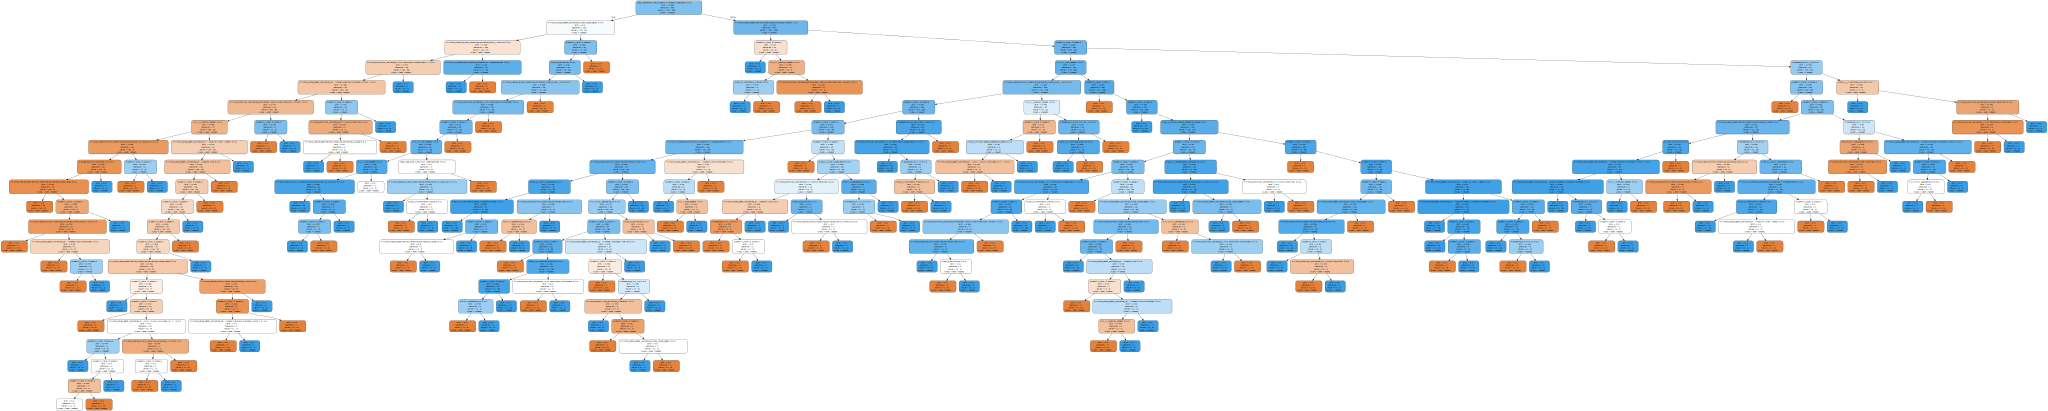

In [150]:
dot_data = tree.export_graphviz(best_clf, out_file=None,
                         feature_names=X.columns.tolist(),
                         class_names=['dont inspect','inspect'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
best_clf.

In [151]:
feature_importance = pd.DataFrame([best_clf.feature_importances_,X.columns.tolist()]).T
feature_importance.columns=['importance','feature']
feature_importance = feature_importance.sort_values('importance',ascending=True)
feature_importance.set_index('feature',inplace=True)

<AxesSubplot:ylabel='feature'>

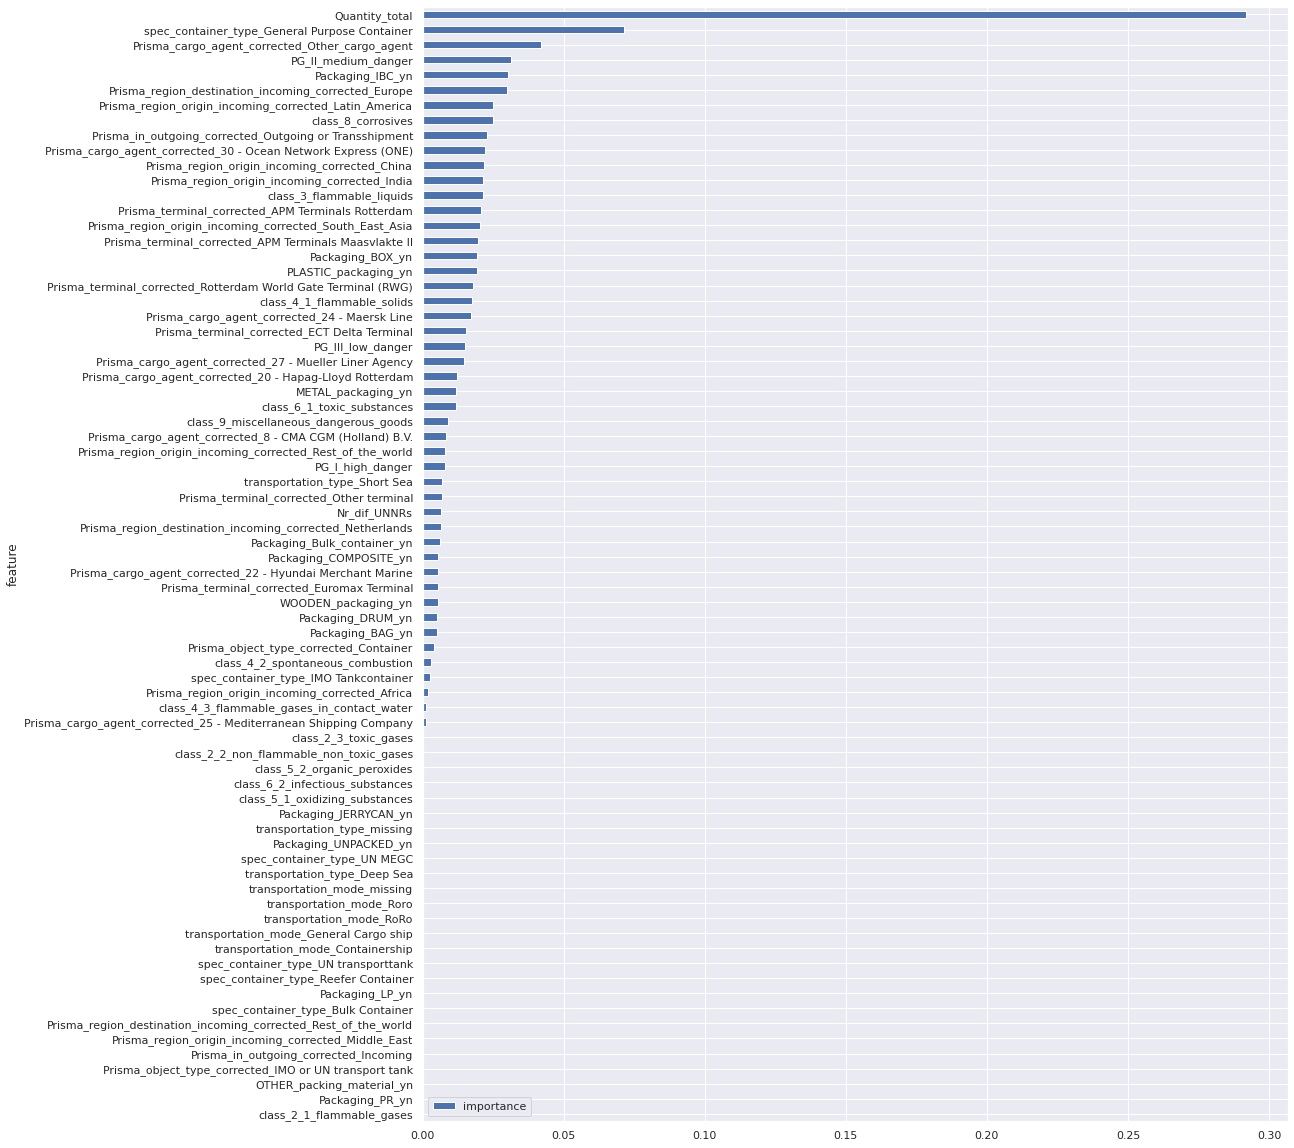

In [152]:
feature_importance.plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(15.5, 20.5)

## Getting the decision path for groups of samples

In [87]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [140]:
#getting the individual path of a sample. 
feature = best_clf.tree_.feature # a list of 
threshold = best_clf.tree_.threshold
node_indicator = best_clf.decision_path(X)
leaf_id = best_clf.apply(X)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id},".format(id=sample_id), 'predicted to be class: ',y[sample_id])
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X.values[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=X.columns.tolist()[feature[node_id]],
            value=X.values[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0, predicted to be class:  1
decision node 0 : (X[0, spec_container_type_General Purpose Container] = 1.0) > 0.5)
decision node 102 : (X[0, Prisma_region_destination_incoming_corrected_Europe] = 1.0) > -0.5)
decision node 112 : (X[0, Quantity_total] = 7250.0) <= 20758.0)
decision node 113 : (X[0, PG_III_low_danger] = 0.0) <= 0.5)
decision node 114 : (X[0, Prisma_region_origin_incoming_corrected_South_East_Asia] = 0.0) <= 0.5)
decision node 115 : (X[0, Quantity_total] = 7250.0) <= 17955.5)
decision node 116 : (X[0, Quantity_total] = 7250.0) <= 15617.0)
decision node 117 : (X[0, Prisma_in_outgoing_corrected_Outgoing or Transshipment] = 0.0) <= 0.5)
decision node 118 : (X[0, Prisma_region_origin_incoming_corrected_China] = 1.0) > 0.5)
decision node 132 : (X[0, Quantity_total] = 7250.0) <= 13790.0)
decision node 133 : (X[0, PLASTIC_packaging_yn] = 0.0) <= 0.5)
decision node 134 : (X[0, Quantity_total] = 7250.0) <= 10716.0)
decision node 135 : (X[0, Quantity_tot

In [137]:
#this is just here to compare easier
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: PG_II_medium_danger > 0.00 AND Quantity_total <= 10106.00 AND Packaging_DRUM_yn > 0.00 AND Prisma_region_destination_incoming_corrected_Netherlands <= 0.00
Precision: 0.95
Coverage: 0.03


We notice that anchors are not so precise as the tree splits. 

From tree :
- Quantity is between(4223,10716)
- Coming from China
- Not transshipment or outgoing
- Not plastic packaging
- Not class 4.1
- Not low danger

However from anchors we get the PG class and packaging type. So maybe an idea is to combine them


In [119]:
help(best_clf.tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [114]:
threshold

array([    0.5,     0.5,     0.5,     0.5,     0.5,     0.5,     0.5,     0.5,     0.5,     0.5,    -2. ,
       25325. ,     0.5,    -2. ,     0.5,    -2. , 19610. ,    -2. ,    -2. ,    -2. ,    -2. , 13214. ,
          -2. ,    -2. ,     0.5,     0.5, 24480. , 23980. , 23860. , 22815. ,     0.5, 18230. ,    -2. ,
       19745. ,    -2. ,     0.5, 22110. ,    -2. , 22755. , 22730. ,    -2. ,    -2. ,    -2. ,    -0.5,
       21700. ,    -2. ,    -2. ,    -2. ,     0.5, 19450. ,    -0.5,    -2. ,    -2. ,    -2. ,    -2. ,
          -2. ,    -2. ,    -2. ,    -2. ,    -2. ,    -2. , 22240. ,    -2. ,    -2. , 18630. ,     0.5,
           0.5,    -2. ,    -2. ,    -2. ,    -2. ,    -2. ,     0.5,    -2. ,    -2. , 26250. ,     0.5,
           0.5,     0.5, 25140. ,     0.5,     0.5,     0.5,    -2. , 21930. , 21910. ,    -2. ,    -2. ,
          -2. ,    -2. ,     0.5,     0.5,    -2. ,     0.5,    -2. ,    -2. ,    -2. ,    -2. ,    -2. ,
          -2. ,    -2. ,    -2. ,    -0.5, 131

In [124]:
from anchor import utils
from anchor import anchor_tabular

In [126]:
#getting the categories mappings for categorical data
# category_map = gen_category_map(X_df)
category_map = {}  # There should be none, since all data is one hot encoded

#getting the feature names
feature_names = X.columns.tolist()

In [127]:
# load a stored model
from joblib import dump, load

model = best_clf

## Getting an anchor
Documentation: https://github.com/marcotcr/anchor/blob/ff0924e6bcaaa7149e2940303cd0b22994112157/anchor/anchor_tabular.py

In [130]:
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names = ['dont inspect', 'inspect'],
    feature_names=feature_names,
    train_data=X.values,
    categorical_names=category_map)

In [134]:
idx = 0
np.random.seed(1)
print('Prediction: ', explainer.class_names[model.predict(X.values[idx].reshape(1, -1))[0]])
# Set the threshold so that we get an anchor with at least 95% precision.
# We can set max anchor size for simpler rules.
exp = explainer.explain_instance(X.values[idx], model.predict, threshold=0.95, max_anchor_size=4)

Prediction:  inspect


In [135]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: PG_II_medium_danger > 0.00 AND Quantity_total <= 10106.00 AND Packaging_DRUM_yn > 0.00 AND Prisma_region_destination_incoming_corrected_Netherlands <= 0.00
Precision: 0.95
Coverage: 0.03


#### ^The coverage tells us that this anchor applies to 3% of the perturbation space’s instances. In those cases, the explanation is 46% accurate.

Note that we set threshold to 0.95, so we guarantee (with high probability) that precision will be above 0.95 - that is, that predictions on instances where the anchor holds will be the same as the original prediction at least 95% of the time. Let's try it out on the test set

In [24]:
# Get test examples where the anchor applies
fit_anchor = np.where(np.all(implem_set[:, exp.features()] == implem_set[idx][exp.features()], axis=1))[0]
print('Anchor test precision: %.2f' % (np.mean(model.predict(implem_set[fit_anchor]) == model.predict(X[idx].reshape(1, -1)))))
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(implem_set.shape[0])))

Anchor test precision: 1.00
Anchor test coverage: 0.00


## Looking at part of the anchor (e.g the first two clauses)

In [25]:
print('Partial anchor: %s' % (' AND '.join(exp.names(1))))
print('Partial precision: %.2f' % exp.precision(1))
print('Partial coverage: %.2f' % exp.coverage(1))

Partial anchor: age_in_months > 249.00 AND GSS_TEU <= -1.00
Partial precision: 0.36
Partial coverage: 0.09


#### ^As might be expected, the partial anchor has higher coverage but is less accurate.

In [26]:
fit_partial = np.where(np.all(implem_set[:, exp.features(1)] == implem_set[idx][exp.features(1)], axis=1))[0]
print('Partial anchor test precision: %.2f' % (np.mean(model.predict(implem_set[fit_partial]) == model.predict(implem_set[idx].reshape(1, -1)))))
print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(implem_set.shape[0])))

Partial anchor test precision: 1.00
Partial anchor test coverage: 0.00


## Visualize the anchor with examples

In [27]:
exp.show_in_notebook()